In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numbers
import math
from datetime import datetime
pd.options.mode.chained_assignment = None 

# Fill in the 2017 April Data

In [3]:
def get_filed_2017_from_2016():
    turbine_telemetry_Qian = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)
    turbine_telemetry_Qian = turbine_telemetry_Qian.reset_index()
    turbine_telemetry_Qian.Timestamp = pd.to_datetime(turbine_telemetry_Qian.Timestamp)
    turbine_telemetry_Qian['Year'] = turbine_telemetry_Qian.Timestamp.dt.year
    turbine_telemetry_Qian['Month'] = turbine_telemetry_Qian.Timestamp.dt.month
    turbine_telemetry_Qian['Day'] = turbine_telemetry_Qian.Timestamp.dt.day
    turbine_telemetry_Qian['Hour'] = turbine_telemetry_Qian.Timestamp.dt.hour
    turbine_telemetry_Qian['Minute'] = turbine_telemetry_Qian.Timestamp.dt.minute
    turbine_telemetry_Qian['Second'] = turbine_telemetry_Qian.Timestamp.dt.second
    
    
    grouped_df = turbine_telemetry_Qian.groupby(['Year','Month'])
    grouped_df = grouped_df.agg({'Day': 'nunique'})
    grouped_df = grouped_df.reset_index()
    location = grouped_df.Year == 2017
    grouped_df.loc[location]
    # The data in April is missing
    
    grouped_df = turbine_telemetry_Qian.groupby(['Year','Month','Day'])
    grouped_df = grouped_df.agg({'Hour': 'nunique'})
    grouped_df = grouped_df.reset_index()
    location = (grouped_df.Year == 2017) & (grouped_df.Month == 4)
    grouped_df.loc[location]
    # The data for April 3rd and April 24th are partially missing, and the data for April 4th to April 23 are entirely missing
    
    # Fill in the missing data for April 3th to April 24.
    # Replace the missing data in 2017 by data in 2016
    masks = (turbine_telemetry_Qian.Year == 2016) &  (turbine_telemetry_Qian.Month == 4) & (turbine_telemetry_Qian.Day.between(3, 24, inclusive=True))
    data_2016_for_replacement = turbine_telemetry_Qian.loc[masks]
    data_2016_for_replacement.Year = 2017
    data_2016_for_replacement.Timestamp = data_2016_for_replacement.Timestamp + pd.offsets.DateOffset(years=1)
    data_2016_for_replacement
    
    turbine_telemetry_filing_in_3_24 = turbine_telemetry_Qian.append(data_2016_for_replacement)
    turbine_telemetry_filing_in_3_24

    # reprint all the data from 2017
    tt_17  = turbine_telemetry_filing_in_3_24.copy()
    mask17 = (tt_17.Year == 2017)
    tt_17  = tt_17[mask17]
    
    tt17 = tt_17.copy()
    tt17 = tt17.reset_index()
    plot_filled_data = tt17.plot.scatter('Timestamp', 'Power_kw')


    return tt17

# Bring all to xx:00 second and take the mean value for all the data from 2017

In [4]:
def isnumber(x):
    return isinstance(x, numbers.Number)

def not_number_to_nan(row):
    power = row.Power_kw
    if isnumber(power):
        return power
    else: 
        return np.nan

def get_all_zero_seconds_avg(tt17):

    tt_17 = tt17.copy()
    tt_17 = tt_17.reset_index()
    tt_17.plot.scatter('Timestamp', 'Power_kw')
        
    tt_17.Timestamp = tt_17.Timestamp.map(lambda x: x.replace(second=0))
    tt_17["Power_kw"] = tt_17.apply( not_number_to_nan, axis =1)
        
    tt17_mean_data = tt17.groupby("Timestamp").mean()
    
    return tt17_mean_data

# Main Exploration

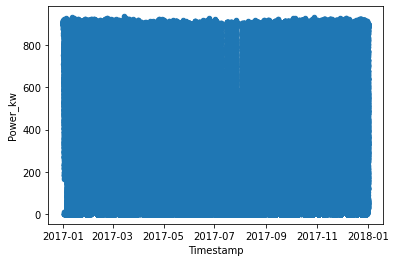

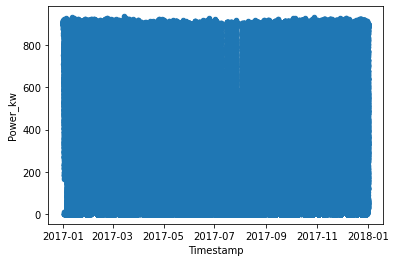

In [5]:
tt = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)

tt17 = get_filed_2017_from_2016()

tt17_mean_data = get_all_zero_seconds_avg(tt17)

# Q1 Assumption

In [6]:
turbines = 500
turbines_operating = 0.8 ##Assumption
orkney_households = 9240

# Q1 First way

In [7]:
def calcucate_curtailed_energy_setpoint_based(tt):

    turbine_telemetry_filter_wind_power = tt.copy()
    turbine_telemetry_filter_wind_power.loc[turbine_telemetry_filter_wind_power.Wind_ms >= 30, "Power_kw"] = 0

    max_setpoints_per_wind = turbine_telemetry_filter_wind_power.groupby('Wind_ms')['Setpoint_kw'].max()

    turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.merge( max_setpoints_per_wind, on = "Wind_ms")

    turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.rename(columns = {"Setpoint_kw_x": "Setpoint_kw", "Setpoint_kw_y": "Max_possible_setpoint" }) 

    turbine_telemetry_filter_wind_power["Setpoint_delta"] = turbine_telemetry_filter_wind_power["Max_possible_setpoint"] - turbine_telemetry_filter_wind_power["Setpoint_kw"]

    turbine_telemetry_filter_wind_power["Power_curtailed"] = turbine_telemetry_filter_wind_power["Setpoint_delta"]
    turbine_telemetry_filter_wind_power.loc[ turbine_telemetry_filter_wind_power.Setpoint_kw > turbine_telemetry_filter_wind_power.Power_kw , "Power_curtailed"] = 0

    total_curtailed_kwh = turbine_telemetry_filter_wind_power["Power_curtailed"].sum()/60

    total_curtailed_energy = turbines * turbines_operating * total_curtailed_kwh

    return total_curtailed_energy, turbine_telemetry_filter_wind_power

# Q1 Second Way: curtailed = (possible power - island demand - export)*t

In [8]:
def get_wind_power_relation(tt):
    # how to figure out what's the the smallest speed necessary to produce power
    v_min = tt[(tt.loc[:, 'Power_kw'] >= 5.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile
    
    #df = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)
    df = tt.query('Setpoint_kw==900').copy()
    
    # remove data points when the wind speed is fast enough for power production but there is no power;
    df.loc[((df.Wind_ms >= v_min) & (df.Power_kw.abs() <= 1e-5))] = np.nan
    
    # remove all missing values from the dataframe
    df = df.dropna(0, inplace=False)
    
    #####################################
    ## select bin locations
    #####################################
    wmax_ = df[df.Power_kw == df.Power_kw.quantile(0.90)].Wind_ms.quantile(0.5)
    wmax  = df.Wind_ms.max()
    
    
    bins = np.arange(0, wmax, .2)
    
    # group data by bins
    df['bins'] = pd.cut(df.Wind_ms, bins) #
    
    df_ = df[['Power_kw', 'bins']].groupby('bins')
    power_med = df_.quantile(0.5)
    power_med['q10'] = df_.quantile(0.1)
    power_med['q90'] = df_.quantile(0.9)
    
    
    # pretty good replication of the power vs wind profile
    plot_power = power_med.plot(rot=45)
    
    
    df['bins'].isna().sum()
    bin_nan = df[df["bins"].isna()]
    
    #####################################
    # look-up table mean and standard deviation
    #####################################
    
    # group data by bins
    cuts = pd.cut(df.Wind_ms, bins)
    gp_  = df.Power_kw.groupby(cuts) # iterator
    
    lutm = gp_.mean()
    luts = gp_.std()
    
    # convert to an interval index
    lutm.index = pd.IntervalIndex(lutm.index)
    luts.index = pd.IntervalIndex(luts.index)
    # this is the basis of our look-up table
    
    
    # round power to nearest 5 watts == 0.05 kW
    lutm = lutm.round(2)
    
    # set final power output to 900
    lutm.loc[wmax_:] = 900
    
    # make zero interval open at both ends to cover zero wind speed
    lutm.loc[pd.Interval(0,.2, closed='right')] = 0 
    
    
    #####################################
    # extend range to gusts of wind that are greater than max operating speed (25m/s) but of short duration
    #####################################
    #lutm.loc[pd.Interval(wmax_, 50, closed='right')] = 900
    #lutm.loc[pd.IntervalIndex.get_indexer_non_unique(lutm.loc[pd.Interval(25, 50)])] = 0


    
    # compare lookup table with data
    plt.figure(figsize=(15,5))
    s = plt.step(lutm.index.right, lutm, color='r')
    plt.legend(s, ['look-up table'], loc='upper left')
    
    #########################################
    gp = df
    mask = (gp.index.year == 2017)
    gp_17 = gp[mask]
    
    
    possible_power = [ 0 if pd.isnull(bini) else lutm[bini] for bini in gp_17.bins  ]
    gp_17 = gp_17.assign(Max_power_available = possible_power)
    

    return gp_17,lutm

# Calculating the Demand

In [9]:
def get_demand_data():
    
    demand = pd.read_csv('residential_demand.csv', parse_dates=[0], index_col=0)
    demand['Demand_mean_kw'] = demand['Demand_mean_kw'] * 8193/365/24/demand.Demand_mean_kw.mean() 
    mask   = (demand.index.year == 2017)
    demand = demand[mask]
    
    demand["Mean_demand"] = demand["Demand_mean_kw"]/demand["N_households"]

    return demand

def calculate_curtailed_energy_mean_demand(gp_17, demand):
    
    gp_17 = gp_17.reset_index()
    gp_17["Timestamp"] = gp_17["Timestamp"].apply(lambda x: pd.Timestamp.replace(x,second=0) )
    gp_17 = gp_17.set_index("Timestamp")
    
    
    curtailed = gp_17.join(demand, how = "outer")
    curtailed = curtailed.drop(columns = ["N_households","Demand_mean_kw", "Wind_ms", "bins"])
    curtailed.index.sort_values()
    
    
    curtailed['Mean_demand']   = curtailed['Mean_demand'].interpolate(method='linear')
    curtailed["island_demand"] = curtailed["Mean_demand"]*orkney_households
    
    
    curtailed_power = curtailed.copy()
    curtailed_power["power_excess"] = turbines_operating*turbines*curtailed["Max_power_available"] - curtailed["island_demand"] - 40000
    curtailed_power = curtailed_power.drop(columns = ["Power_kw","Setpoint_kw", "Max_power_available","Mean_demand", "island_demand"])
    
    curtailed_power.loc[curtailed_power['power_excess'] < 0, 'power_excess'] = 0
    
    total_curtailed_energy_kwh = curtailed_power["power_excess"].sum()/60

    return total_curtailed_energy_kwh, curtailed_power

In [160]:
curtailed_power.groupby(['Month'])['power_excess'].sum()

Month
1.0     1.191238e+09
2.0     1.044514e+09
3.0     9.080037e+08
4.0     6.715769e+08
5.0     4.951554e+08
6.0     5.143863e+08
7.0     3.445407e+08
8.0     4.127667e+08
9.0     5.756826e+08
10.0    1.006758e+09
11.0    1.349806e+09
12.0    1.102870e+09
Name: power_excess, dtype: float64

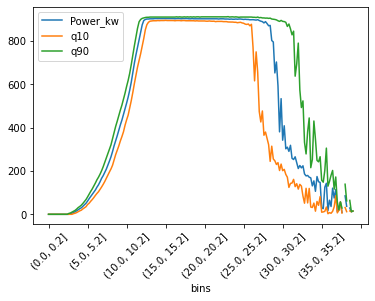

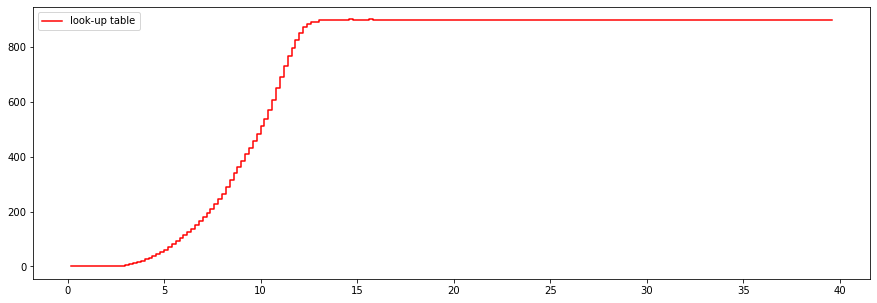

In [96]:
total_curtailed_energy_1way, turbine_telemetry_filter_wind_power = calcucate_curtailed_energy_setpoint_based(tt17_mean_data)
gp_17,lutm = get_wind_power_relation(tt17_mean_data)
demand = get_demand_data()
total_curtailed_energy_2nd, curtailed_power = calculate_curtailed_energy_mean_demand(gp_17, demand)

adjusting_Ratio=65*1000/500/900
curtailed_power['power_excess']=curtailed_power['power_excess']*adjusting_Ratio
total_curtailed_energy_2nd=total_curtailed_energy_2nd*adjusting_Ratio

In [100]:
curtailed_power

,index,Year,Month,Day,Hour,Minute,Second,power_excess
Timestamp,,,,,,,,
2017-01-01 00:00:00,558731.0,2017.0,1.0,1.0,0.0,0.0,20.0,46048.080074
2017-01-01 00:01:00,558732.0,2017.0,1.0,1.0,0.0,1.0,20.0,44663.147238
2017-01-01 00:02:00,558733.0,2017.0,1.0,1.0,0.0,2.0,20.0,46180.969957
2017-01-01 00:03:00,558734.0,2017.0,1.0,1.0,0.0,3.0,20.0,46087.948231
2017-01-01 00:04:00,558735.0,2017.0,1.0,1.0,0.0,4.0,20.0,45811.193173
...,...,...,...,...,...,...,...,...
2017-12-31 23:55:00,1054875.0,2017.0,12.0,31.0,23.0,55.0,32.0,0.000000
2017-12-31 23:56:00,1054876.0,2017.0,12.0,31.0,23.0,56.0,32.0,0.000000
2017-12-31 23:57:00,1054877.0,2017.0,12.0,31.0,23.0,57.0,32.0,0.000000


# Function: return the curtailed energy based on the number of household(assuming heating all years)

In [161]:
def saved_curtailmend_power(DR_penetration_perc):
    # import new dataset
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')
    Udemand=demand.reset_index()
    Ucurtailed_power=curtailed_power.reset_index()
    
    # Merge and filter table

    combined_table_2 = pd.merge(Udemand,Ucurtailed_power, how ='left',on=['Timestamp']) 
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    DR_penetration_num= orkney_households*DR_penetration_perc
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    #calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households

    combined_table_2['household_with_DR']=DR_penetration_num

    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']

    # replace negative/NaN saved curtailment energy by 0

    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)


    #Print yearly_saved_energy(mwh)
    yearly_saved_energy = pd.DataFrame(combined_table_2.groupby(['Month'])['saved_curtailment_kwh'].sum()).reset_index()
    yearly_saved_energy.Month = yearly_saved_energy.apply(lambda row: int(row.Month),axis=1)
    return yearly_saved_energy,combined_table_2


# Function: return the curtailed energy based on the number of household(assuming heating only in winters)

In [101]:
def saved_curtailmend_power_seasonal(DR_penetration_perc,DR_month_1=12,DR_month_2=11,DR_month_3=1):


    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')
    Udemand=demand.reset_index()
    Ucurtailed_power=curtailed_power.reset_index()

    combined_table_2 = pd.merge(Udemand,Ucurtailed_power, how ='left',on=['Timestamp']) 
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 


    combined_table_2=combined_table_2[ (combined_table_2['Month']== DR_month_1) | (combined_table_2['Month']== DR_month_2)  | (combined_table_2['Month']== DR_month_3)  ] 

    # add residential heating electricity assumption into combine dataframe
    DR_penetration_num= orkney_households*DR_penetration_perc
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    #calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households

    combined_table_2['household_with_DR']=DR_penetration_num

    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']

    # replace negative/NaN saved curtailment energy by 0

    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)


    #Print yearly_saved_energy(mwh)
    yearly_saved_energy = pd.DataFrame(combined_table_2.groupby(['Month'])['saved_curtailment_kwh'].sum())
    month = list(range(1,13))
    monthly_saved_energy = pd.DataFrame(data = month,columns=['Month'])
    monthly_saved_energy = pd.merge(monthly_saved_energy,yearly_saved_energy,how = 'left',on=['Month']) 
    monthly_saved_energy['saved_curtailment_kwh'] = monthly_saved_energy['saved_curtailment_kwh'].fillna(0)
    return monthly_saved_energy,combined_table_2

In [129]:
monthly_saved_energy,combined_table_2 = saved_curtailmend_power_seasonal(0.1)
combined_table_2.addi_demand_by_DR_kwh.mean()/924

0.08327025986164498

# Function: NPV analysis

In [379]:
def return_wholesale_price():
    col_list = ['YEAR','MONTH', 'WHOLESALE PRICE(￡/MWh）']
    wholesale_price = pd.read_csv('wholesale_price.csv',usecols=col_list) # https://www.businesselectricityprices.org.uk/retail-versus-wholesale-prices/
    wholesale_price['Cumulative_Month'] = wholesale_price.index.values + 1
    return wholesale_price

In [380]:
def return_Revenue_for_generator(n,p_energy,P1): 
    return p_energy*P1

def return_Loss_for_all_household(p_energy,P3,P2):
    return p_energy*(P2-P3)

def return_Financial_benefits_to_Kaluza(n,p_energy,P2,P1,FC,VC):
    return n * p_energy * (P2-P1) -  FC - VC * n

In [398]:
def return_Net_Cash_flow_Kaluza(year_index,ideal_penetration):
    
    
    def return_degree_of_penetration(year_index,total_number_household,ideal_penetration):
        x_list = np.arange(0.1, 1.1, 0.1).tolist()
#         y_list = [(1-math.exp(-x))*total_number_household*ideal_penetration for x in x_list]np.arange(0.1, 1.1, 0.1).tolist()

        y_list = [x*total_number_household*ideal_penetration for x in x_list]

        return y_list[year_index]

    
    monthly_saved_energy,combined_table_2 = saved_curtailmend_power(degree)
    p_energy=monthly_saved_energy.saved_curtailment_kwh
    total_number_household = 10385
    n = int(return_degree_of_penetration(year_index,total_number_household,ideal_penetration))
    wholesale_price = return_wholesale_price()
    P1 = wholesale_price.loc[wholesale_price.YEAR == 17]
    P1 = 56/1000
                # The unit is (GBP/KWh)
                # the wholesale price is the generator sells the energy in the general market (based on online data)

    P2 = 7.5 * 0.01 # The unit is (GBP/KWh)
                # There is the gas price which the local residents are used for heating
                # https://www.thegreenage.co.uk/cheaper-heat-home-gas-electricity/
    P3 = 60/1000 # The unit is (GBP/KWh)
                # This is the electricity price that the local residents will use for heating  
                # https://www.thegreenage.co.uk/cheaper-heat-home-gas-electricity/

    FC = 100 # The unit is (GBP/Household)
             # the installment cost of this DR program 
    VC = 1 # The unit is (GBP/month * household） 
    
    
    month = monthly_saved_energy.Month.unique()
    table_Q2 = pd.DataFrame(data = month,columns=['Month']).set_index('Month')
    table_Q2 = pd.merge(table_Q2,monthly_saved_energy,how='inner',on=['Month'])
    table_Q2['year_index'] = year_index
    table_Q2['n'] = n
    table_Q2['n'] = table_Q2['n'].fillna(table_Q2['n'].mean())
    n_minus_1 = list(table_Q2.n)
    table_Q2['New_Installment'] = 0
    table_Q2['New_Installment'].iloc._setitem_with_indexer(0,total_number_household*ideal_penetration*0.1)
    table_Q2['P1(￡/KWh)'] = P1
    table_Q2['P3(￡/KWh)'] = P3
    table_Q2['P2(￡/KWh)'] = P2
    table_Q2['FC(￡)'] = FC
    table_Q2['VC(￡)'] = VC
    table_Q2['Revenue_Generator'] = table_Q2.apply(lambda row:return_Revenue_for_generator(row['n'],row['saved_curtailment_kwh'],row['P1(￡/KWh)']),axis=1)
    table_Q2['Loss_All_Household'] = table_Q2.apply(lambda row:return_Loss_for_all_household(row['saved_curtailment_kwh'],row['P3(￡/KWh)'],row['P2(￡/KWh)']),axis=1)
    table_Q2['Revenue_minus_Loss'] = table_Q2['Revenue_Generator'] + table_Q2['Loss_All_Household']
    table_Q2['Net_Income_for_Generator'] = table_Q2['Revenue_minus_Loss']/3*1
    table_Q2['Net_Income_for_Kaluza'] = table_Q2['Revenue_minus_Loss']/3*2
    table_Q2['Fixed_Cost_Kaluza'] = table_Q2['New_Installment']*100*1.2
    table_Q2['Variable_Cost_Kaluza'] = VC * table_Q2['n']
    table_Q2['Total_cost_Kaluza'] = table_Q2['Fixed_Cost_Kaluza'] + table_Q2['Variable_Cost_Kaluza']
    table_Q2['Net_Cash_flow_Kaluza'] = table_Q2['Net_Income_for_Kaluza'] - table_Q2['Total_cost_Kaluza']
    return table_Q2

In [399]:
def add_NPV(table):
    def return_npv(month,value):
        monthly_discount_rate = 0.07/12
        return value/(1+monthly_discount_rate)**(month-1)
    table['Discounted_cash_flow'] = table.apply(lambda row: return_npv(row.Month,row.Net_Cash_flow_Kaluza),axis=1)
    table['NPV'] = table['Discounted_cash_flow'].cumsum()
    return table

In [400]:
def return_yearly_revenue_based_on_ideal_pentration(ideal_pentration):
    years_list = list(range(0,10))
    total_cash_flow_list = [return_Net_Cash_flow_Kaluza(year_index,ideal_pentration) for year_index in years_list]
    total_cash_flow_model = pd.concat(total_cash_flow_list).reset_index().drop(columns=['index','P1(￡/KWh)','P2(￡/KWh)','P3(￡/KWh)','FC(￡)','VC(￡)'])
    NPV_model = add_NPV(total_cash_flow_model)
    yearly_revenue = NPV_model.groupby(['year_index'])['Discounted_cash_flow'].sum()
    return yearly_revenue,years_list
#     return total_cash_flow_model,years_list

In [401]:
# yearly_revenue_90,years_list = return_yearly_revenue_based_on_ideal_pentration(0.9)
# yearly_revenue_75,years_list = return_yearly_revenue_based_on_ideal_pentration(0.75)
# yearly_revenue_50,years_list = return_yearly_revenue_based_on_ideal_pentration(0.5)

yearly_revenue_list_90,years_list = return_yearly_revenue_based_on_ideal_pentration(0.9)
yearly_revenue_list_75,years_list = return_yearly_revenue_based_on_ideal_pentration(0.75)
yearly_revenue_list_50,years_list = return_yearly_revenue_based_on_ideal_pentration(0.5)


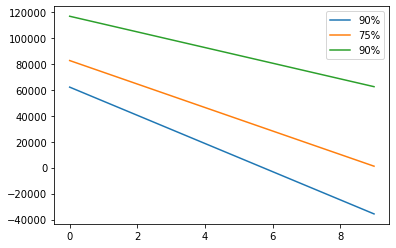

In [409]:
plt.plot(years_list,yearly_revenue_list_90,label='90%')
plt.plot(years_list,yearly_revenue_list_75,label='75%')
plt.plot(years_list,yearly_revenue_list_50,label='90%')
plt.legend()

In [405]:
yearly_revenue_list_50

year_index
0    116778.881416
1    110745.746882
2    104712.612348
3     98667.853277
4     92634.718743
5     86601.584209
6     80568.449675
7     74523.690605
8     68490.556071
9     62457.421537
Name: Discounted_cash_flow, dtype: float64

In [406]:
yearly_revenue_list_75

year_index
0    82613.126417
1    73557.612348
2    64502.098279
3    55446.584209
4    46391.070140
5    37335.556071
6    28280.042001
7    19224.527932
8    10180.638399
9     1125.124330
Name: Discounted_cash_flow, dtype: float64

In [403]:
total_cash_flow_list_90.to_excel("output_90.xlsx",sheet_name='90') 

FileCreateError: [Errno 13] Permission denied: 'output_90.xlsx'

In [ ]:
total_cash_flow_list_75.to_excel("output_75.xlsx",sheet_name='75') 

In [ ]:
total_cash_flow_list_50.to_excel("output_50.xlsx",sheet_name='50') 